In [128]:
import pandas as pd
import numpy as np
from confidenceinterval import classification_report_with_ci


In [368]:
# Define the full list of possible labels
all_labels = [
    "in_silico", "organs", "other", "human", "in_vivo", 
    "invertebrate", "primary_cells", "immortal_cell_line"
]

# Create a mapping for each label to a unique index for one-hot encoding
label_to_index = {label: idx+1 for idx, label in enumerate(all_labels)}

# Function to convert a label or comma-separated labels into a one-hot encoded array
def labels_to_one_hot(labels, label_to_index, num_classes=len(all_labels)):
    # Handle missing or None labels by returning a zero-array
    if pd.isna(labels) or labels == 'none':
        return np.zeros(num_classes, dtype=int)
    
    # Split the labels if multiple (i.e., separated by commas)
    individual_labels = labels.split(',')
    # Initialize one-hot array
    one_hot = np.zeros(num_classes, dtype=int)
    # Set indices corresponding to the labels to 1
    for label in individual_labels:
        if label in label_to_index:  # Only mark labels that are in the predefined list
            one_hot[label_to_index[label]-1] = 1
    return one_hot

def convert_to_class_labels(one_hot_encoded_list):
    return [i+1 if val == 1 else 0 for i, val in enumerate(one_hot_encoded_list)]


In [370]:
label_to_index

{'in_silico': 1,
 'organs': 2,
 'other': 3,
 'human': 4,
 'in_vivo': 5,
 'invertebrate': 6,
 'primary_cells': 7,
 'immortal_cell_line': 8}

In [376]:
model_predictions_folder = "model_predictions"
models_to_eval = ["BioLinkBERT-base", "biobert-v1.1", "BiomedNLP-BiomedBERT-base-uncased-abstract"]

# Dictionary to store DataFrames for each model
model_dfs = {}

# Loop through each model
for model_name in models_to_eval:
    all_splits = []  # Temporary list to store all splits for the current model

    # Loop through splits 0 to 9
    for split in range(10):
        # Define file paths for the current split
        test_content = f"corpus_annotations/test{split}.txt"
        preds_content = f"{model_predictions_folder}/{model_name}_preds_{split}_goldhamster.txt"

        # Load test and prediction files
        df_test = pd.read_csv(test_content, sep="\t", names=["ID", "Target"])
        df_preds = pd.read_csv(preds_content, sep="\t", names=["ID", "Prediction"])

        # Merge on ID to align targets and predictions
        df_merged = pd.merge(df_test, df_preds, on="ID")

        df_merged['Target_num'] = df_merged['Target'].apply(lambda x: labels_to_one_hot(x, label_to_index))
        df_merged['Prediction_num'] = df_merged['Prediction'].apply(lambda x: labels_to_one_hot(x, label_to_index))

        df_merged['Target_num_labeled'] = df_merged['Target_num'].apply(convert_to_class_labels)
        df_merged['Prediction_num_labeled'] = df_merged['Prediction_num'].apply(convert_to_class_labels)
        # Append the merged DataFrame for this split
        all_splits.append(df_merged)

    if model_name == "BiomedNLP-BiomedBERT-base-uncased-abstract":
        model_name = "PubMedBERT"
    # Concatenate all splits into a single DataFrame for the current model
    model_dfs[model_name] = pd.concat(all_splits, ignore_index=True)



In [378]:
model_dfs['BioLinkBERT-base']

,ID,Target,Prediction,Target_num,Prediction_num,Target_num_labeled,Prediction_num_labeled
0,31705587,none,invertebrate,"[0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 1, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 6, 0, 0]"
1,30807815,"immortal_cell_line,primary_cells,human,in_vivo","other,in_vivo","[0, 0, 0, 1, 1, 0, 1, 1]","[0, 0, 1, 0, 1, 0, 0, 0]","[0, 0, 0, 4, 5, 0, 7, 8]","[0, 0, 3, 0, 5, 0, 0, 0]"
2,30594027,"immortal_cell_line,invertebrate,human",in_vivo,"[0, 0, 0, 1, 0, 1, 0, 1]","[0, 0, 0, 0, 1, 0, 0, 0]","[0, 0, 0, 4, 0, 6, 0, 8]","[0, 0, 0, 0, 5, 0, 0, 0]"
3,30879321,immortal_cell_line,immortal_cell_line,"[0, 0, 0, 0, 0, 0, 0, 1]","[0, 0, 0, 0, 0, 0, 0, 1]","[0, 0, 0, 0, 0, 0, 0, 8]","[0, 0, 0, 0, 0, 0, 0, 8]"
4,30818821,immortal_cell_line,"in_vivo,immortal_cell_line","[0, 0, 0, 0, 0, 0, 0, 1]","[0, 0, 0, 0, 1, 0, 0, 1]","[0, 0, 0, 0, 0, 0, 0, 8]","[0, 0, 0, 0, 5, 0, 0, 8]"
...,...,...,...,...,...,...,...
709,31121175,in_vivo,in_vivo,"[0, 0, 0, 0, 1, 0, 0, 0]","[0, 0, 0, 0, 1, 0, 0, 0]","[0, 0, 0, 0, 5, 0, 0, 0]","[0, 0, 0, 0, 5, 0, 0, 0]"
710,31334391,in_vivo,in_vivo,"[0, 0, 0, 0, 1, 0, 0, 0]","[0, 0, 0, 0, 1, 0, 0, 0]","[0, 0, 0, 0, 5, 0, 0, 0]","[0, 0, 0, 0, 5, 0, 0, 0]"
711,30820999,in_vivo,in_vivo,"[0, 0, 0, 0, 1, 0, 0, 0]","[0, 0, 0, 0, 1, 0, 0, 0]","[0, 0, 0, 0, 5, 0, 0, 0]","[0, 0, 0, 0, 5, 0, 0, 0]"
712,31140380,in_vivo,in_vivo,"[0, 0, 0, 0, 1, 0, 0, 0]","[0, 0, 0, 0, 1, 0, 0, 0]","[0, 0, 0, 0, 5, 0, 0, 0]","[0, 0, 0, 0, 5, 0, 0, 0]"


In [380]:
label_to_index

{'in_silico': 1,
 'organs': 2,
 'other': 3,
 'human': 4,
 'in_vivo': 5,
 'invertebrate': 6,
 'primary_cells': 7,
 'immortal_cell_line': 8}

In [382]:
mapping = {
    0: 'no annotation',
    1: 'in_silico',
    2: 'organs',
    3: 'other',
    4: 'human',
    5: 'in_vivo',
    6: 'invertebrate',
    7: 'primary_cells',
    8: 'immortal_cell_line'
}

model_class_report = {}
model_class_per_label_report = {}

for model, results in model_dfs.items():
    # Flattening Target_num and Prediction_num columns to a single numeric array
    target_flat = np.concatenate(results['Target_num'].values)
    prediction_flat = np.concatenate(results['Prediction_num'].values)   
    df_classification_report = classification_report_with_ci(target_flat,prediction_flat)

    target_flat_labeled = np.concatenate(results['Target_num_labeled'].values)
    prediction_flat_labeled = np.concatenate(results['Prediction_num_labeled'].values)

    df_classification_report_per_label = classification_report_with_ci(target_flat_labeled, prediction_flat_labeled, numerical_to_label_map=mapping)

    model_class_report[model] = df_classification_report
    model_class_per_label_report[model] = df_classification_report_per_label

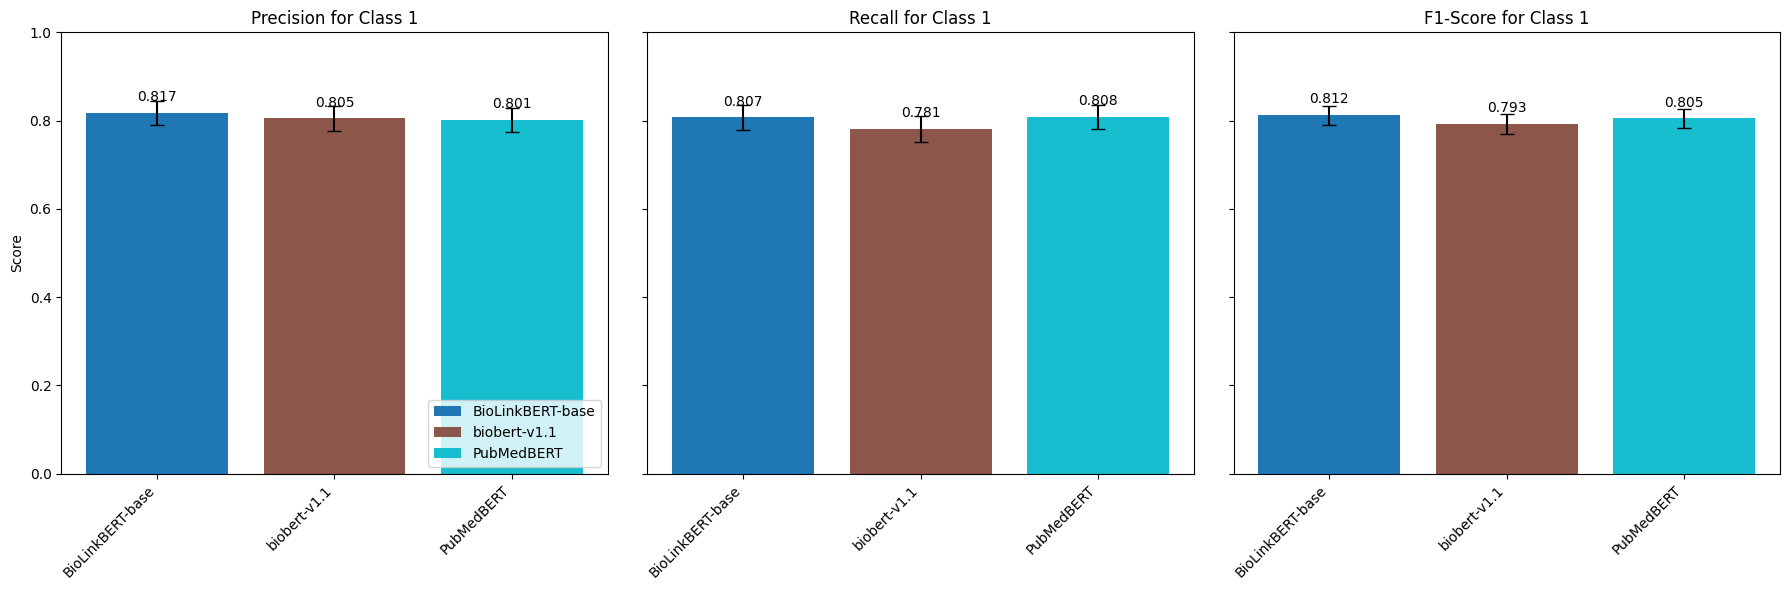

In [384]:
import matplotlib.pyplot as plt
import numpy as np

# Define sample data structure for model_class_report
# model_class_report = {
#     "BioLinkBERT-base": your_dataframe_for_this_model,
#     "biobert-v1.1": another_dataframe,
#     ...
# }

# Define lists to hold metrics data
model_names = []
precision_values = []
recall_values = []
f1_values = []
precision_cis = []
recall_cis = []
f1_cis = []

# Loop through each model in model_class_report to extract data for Class 1
for model_name, df in model_class_report.items():
    # Filter for Class 1 row and retrieve the precision, recall, f1, and CIs
    class_1_row = df[df['Class'] == 'Class 1']
    
    model_names.append(model_name)
    precision_values.append(class_1_row['Precision'].values[0])
    recall_values.append(class_1_row['Recall'].values[0])
    f1_values.append(class_1_row['F1-Score'].values[0])
    
    # Unpack confidence intervals and calculate error margins
    precision_cis.append((class_1_row['Precision CI'].values[0][1] - class_1_row['Precision CI'].values[0][0]) / 2)
    recall_cis.append((class_1_row['Recall CI'].values[0][1] - class_1_row['Recall CI'].values[0][0]) / 2)
    f1_cis.append((class_1_row['F1-Score CI'].values[0][1] - class_1_row['F1-Score CI'].values[0][0]) / 2)

# Define color palette for models
colors = plt.cm.tab10(np.linspace(0, 1, len(model_names)))

# Plotting the metrics with confidence intervals for each model
fig, ax = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Precision plot
for i, (value, ci, color) in enumerate(zip(precision_values, precision_cis, colors)):
    ax[0].bar(model_names[i], value, yerr=ci, capsize=5, color=color, label=model_names[i])
    ax[0].text(i, value + 0.02, f"{value:.3f}", ha='center', va='bottom')
ax[0].set_title("Precision for Class 1")
ax[0].set_ylabel("Score")
ax[0].set_ylim(0, 1)
ax[0].legend(loc="lower right")
ax[0].set_xticks(range(len(model_names)))
ax[0].set_xticklabels(model_names, rotation=45, ha="right")

# Recall plot
for i, (value, ci, color) in enumerate(zip(recall_values, recall_cis, colors)):
    ax[1].bar(model_names[i], value, yerr=ci, capsize=5, color=color)
    ax[1].text(i, value + 0.02, f"{value:.3f}", ha='center', va='bottom')
ax[1].set_title("Recall for Class 1")
ax[1].set_ylim(0, 1)
ax[1].set_xticks(range(len(model_names)))
ax[1].set_xticklabels(model_names, rotation=45, ha="right")

# F1-Score plot
for i, (value, ci, color) in enumerate(zip(f1_values, f1_cis, colors)):
    ax[2].bar(model_names[i], value, yerr=ci, capsize=5, color=color)
    ax[2].text(i, value + 0.02, f"{value:.3f}", ha='center', va='bottom')
ax[2].set_title("F1-Score for Class 1")
ax[2].set_ylim(0, 1)
ax[2].set_xticks(range(len(model_names)))
ax[2].set_xticklabels(model_names, rotation=45, ha="right")

# Display plot
plt.tight_layout()
plt.show()


In [386]:
summary_data = {
    "Model": model_names,
    "Precision": precision_values,
    "Precision CI": [f"({round(value - ci, 3)}, {round(value + ci, 3)})" for value, ci in zip(precision_values, precision_cis)],
    "Recall": recall_values,
    "Recall CI": [f"({round(value - ci, 3)}, {round(value + ci, 3)})" for value, ci in zip(recall_values, recall_cis)],
    "F1-Score": f1_values,
    "F1-Score CI": [f"({round(value - ci, 3)}, {round(value + ci, 3)})" for value, ci in zip(f1_values, f1_cis)],
}

# Create a DataFrame
summary_df = pd.DataFrame(summary_data)
summary_df

,Model,Precision,Precision CI,Recall,Recall CI,F1-Score,F1-Score CI
0,BioLinkBERT-base,0.817,"(0.79, 0.844)",0.807,"(0.78, 0.834)",0.812,"(0.79, 0.834)"
1,biobert-v1.1,0.805,"(0.778, 0.832)",0.781,"(0.752, 0.81)",0.793,"(0.771, 0.816)"
2,PubMedBERT,0.801,"(0.774, 0.828)",0.808,"(0.781, 0.835)",0.805,"(0.783, 0.827)"


In [388]:
from sklearn.metrics import f1_score

In [390]:
f1_score(target_flat,prediction_flat)

0.8047411104179664

In [392]:
f1_score(target_flat,prediction_flat, average='micro')

0.945203081232493

In [394]:
f1_score(target_flat,prediction_flat, average='macro')

0.8864353143984751

## Per Class

In [397]:
# Initialize the dictionary to hold the final transformed structure
label_f1_summary = {}

# Loop through each model and extract F1-score results
for model_name, df in model_class_per_label_report.items():
    for _, row in df.iterrows():
        label = row['Class']
        if label == "no annotation" or label == "micro" or label == "macro":
            continue
        # Extract F1-score and confidence intervals
        f1_score = row['F1-Score']
        f1_ci = row['F1-Score CI']  # Example: (0.961, 0.991) as a tuple
        
        # Unpack the confidence interval directly
        lower_bound, upper_bound = f1_ci  # Since f1_ci is already a tuple
        
        # Initialize the label entry if it doesn't exist
        if label not in label_f1_summary:
            label_f1_summary[label] = {}
        
        # Append the F1 score tuple (lower bound, score, upper bound) for each model
        label_f1_summary[label][model_name] = [(lower_bound, f1_score, upper_bound)]


In [409]:
model_class_per_label_report

{'BioLinkBERT-base':                  Class  Precision  Recall  F1-Score    Precision CI  \
 0        no annotation      0.969   0.971     0.970  (0.963, 0.973)   
 1            in_silico      0.805   0.816     0.810  (0.703, 0.878)   
 2               organs      0.867   0.867     0.867  (0.778, 0.924)   
 3                other      0.686   0.588     0.633  (0.591, 0.768)   
 4                human      0.843   0.812     0.827  (0.762, 0.899)   
 5              in_vivo      0.889   0.907     0.898   (0.84, 0.925)   
 6         invertebrate      0.875   0.907     0.891  (0.801, 0.924)   
 7        primary_cells      0.614   0.600     0.607  (0.466, 0.743)   
 8   immortal_cell_line      0.722   0.765     0.743  (0.591, 0.824)   
 9                micro      0.948   0.948     0.948  (0.942, 0.954)   
 10               macro      0.808   0.804     0.805  (0.775, 0.841)   
 
          Recall CI     F1-Score CI  Support  
 0   (0.966, 0.975)  (0.964, 0.975)     4914  
 1   (0.714, 0.887) 

In [399]:
label_f1_summary

{'in_silico': {'BioLinkBERT-base': [(0.742, 0.81, 0.878)],
  'biobert-v1.1': [(0.727, 0.797, 0.868)],
  'PubMedBERT': [(0.748, 0.816, 0.885)]},
 'organs': {'BioLinkBERT-base': [(0.812, 0.867, 0.923)],
  'biobert-v1.1': [(0.741, 0.807, 0.873)],
  'PubMedBERT': [(0.789, 0.847, 0.906)]},
 'other': {'BioLinkBERT-base': [(0.559, 0.633, 0.708)],
  'biobert-v1.1': [(0.562, 0.635, 0.708)],
  'PubMedBERT': [(0.558, 0.632, 0.705)]},
 'human': {'BioLinkBERT-base': [(0.773, 0.827, 0.882)],
  'biobert-v1.1': [(0.75, 0.807, 0.865)],
  'PubMedBERT': [(0.73, 0.789, 0.848)]},
 'in_vivo': {'BioLinkBERT-base': [(0.867, 0.898, 0.929)],
  'biobert-v1.1': [(0.834, 0.87, 0.907)],
  'PubMedBERT': [(0.857, 0.89, 0.923)]},
 'invertebrate': {'BioLinkBERT-base': [(0.847, 0.891, 0.935)],
  'biobert-v1.1': [(0.849, 0.893, 0.937)],
  'PubMedBERT': [(0.856, 0.898, 0.94)]},
 'primary_cells': {'BioLinkBERT-base': [(0.487, 0.607, 0.727)],
  'biobert-v1.1': [(0.492, 0.606, 0.72)],
  'PubMedBERT': [(0.535, 0.642, 0.748)]}

In [401]:
def alt_bands_x_axis(ax=None):
    ax = ax or plt.gca()
    x_left, x_right = ax.get_xlim()
    locs = ax.get_xticks()
    for loc1, loc2 in zip(locs[::2], np.concatenate((locs, [x_right]))[1::2]):
        ax.axvspan(loc1, loc2, facecolor='black', alpha=0.2)
    ax.set_xlim(x_left, x_right)

def alt_bands_y_axis(ax=None):
    ax = ax or plt.gca()
    y_left, y_right = ax.get_ylim()
    locs = ax.get_yticks()
    #print(locs)
    for loc1, loc2 in zip(locs[::2], np.concatenate((locs, [y_right]))[1::2]):
        ax.axhspan(loc1 + 1.4, loc2 - 0.6, facecolor='grey', alpha=0.15)
    ax.set_ylim(y_left, y_right)

In [403]:
colors = {
    'BioLinkBERT-base': '#D55E00',                    
    'biobert-v1.1': '#009E73',            
    'PubMedBERT': '#E69F00',       
    #'gpt-3.5-turbo': '#0072B2',           
    #'gpt-4': '#56B4E9',                   
    #'aact': '#CC79A7',        
    #'regex': '#000000'
    
}

In [405]:
entity_order = [
    "invertebrate",
    "in_vivo",
    "human",
    "organs",
    "primary_cells",
    "immortal_cell_line",
    "in_silico",
    "other"
]
entity_labels = [
    "invertebrates",
    "in_vivo",
    "human",
    "organs",
    "primary_cells",
    "immortal_cell_lines",
    "in_silico",
    "other"
]

['BioLinkBERT-base', 'biobert-v1.1', 'PubMedBERT', 'BioLinkBERT-base', 'biobert-v1.1', 'PubMedBERT', 'BioLinkBERT-base', 'biobert-v1.1', 'PubMedBERT', 'BioLinkBERT-base', 'biobert-v1.1', 'PubMedBERT', 'BioLinkBERT-base', 'biobert-v1.1', 'PubMedBERT', 'BioLinkBERT-base', 'biobert-v1.1', 'PubMedBERT', 'BioLinkBERT-base', 'biobert-v1.1', 'PubMedBERT', 'BioLinkBERT-base', 'biobert-v1.1', 'PubMedBERT']


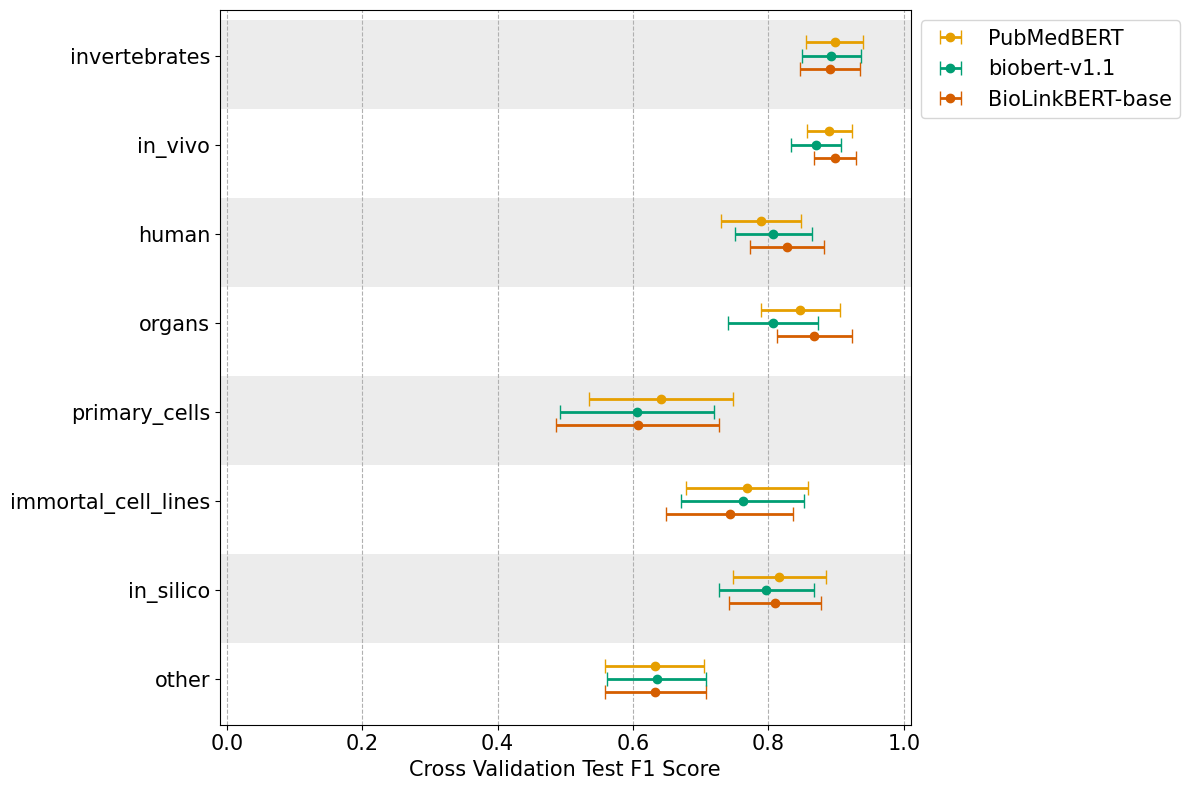

In [407]:
results = label_f1_summary
fig, ax = plt.subplots(figsize=(12, 8))
model_spacing = 0.15  # Spacing between models within the same entity type
entity_spacing = 0.5  # Additional spacing between different entity types

# Iterate over each entity type in the predefined order
for i, entity_type in enumerate(entity_order[::-1]):
    model_index = 0  # Reset model index for each entity type
    if entity_type in results:
        num_models = len(results[entity_type])
        for model_name, data in results[entity_type].items():
            center = data[0][1]
            lower, upper = data[0][0], data[0][2]
            #model_name = model_name.split("_")[1]
            color = colors[model_name]
            
            # Plot
            y_position = i + (model_index - num_models / 3) * model_spacing
            ax.errorbar(center, y_position, xerr=[[center - lower], [upper - center]], elinewidth = 2, fmt='o', color=color, capsize=5, label=model_name )#if i == 0 else "")
            #if center == 0: 
            #    ax.text(center, y_position, f"{center:.0f}", ha='center', va='bottom')
            #else:
            #    ax.text(center, y_position, f"{center:.2f}", ha='center', va='bottom')
            model_index += 1  
            
# Setting the y-ticks according to the new entity order
ax.set_yticks(np.arange(len(entity_order)))
ax.set_yticklabels(entity_labels[::-1], fontsize=15)

ax.set_xlabel('Cross Validation Test F1 Score', fontsize=15)
#ax.set_title('Performance by Entity Type (entity frequency in test, frequency in train)', fontsize=14)
ax.grid(True, axis='x', linestyle='--',)
ax.tick_params(axis='x', labelsize=15)
ax.set_xlim([-0.01, 1.01])

alt_bands_y_axis(ax)

# Creating a legend that doesn't repeat labels
handles, labels = plt.gca().get_legend_handles_labels()

print(labels)
# Add 'regex' to the legend
#handles.append(ax.errorbar(0, 0, xerr=[[0], [0]], color=colors['regex'], fmt='o', elinewidth = 3, capsize=5, label='regex'))
#labels.append('regex')
# Reverse handles and labels
handles = handles [::-1]
labels = labels [::-1]
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc='upper left', fontsize=15, bbox_to_anchor=(1, 1))

#ax.legend(by_label.values(), by_label.keys(), loc='upper left', fontsize=14)

plt.tight_layout()
#plt.savefig("./evaluations/plots/rebuttal_all_entities_performance_v153_test.pdf")
plt.show()